In [ ]:
from utk_functions import data_train_test_utk

X_train, X_test, Y_train, Y_test, sensitive, sensitive_t = data_train_test_utk()

In [ ]:
print("hello")

In [ ]:
import operator
import numpy as np
import pandas as pd
import os
from keras.layers import RandomFlip, Conv2D, GroupNormalization, MaxPooling2D, Dense, Flatten
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras import Sequential, Input
from keras.src.saving.saving_api import load_model, save_model
from keras.utils import set_random_seed
import keras
import tensorflow as tf

class DatasetWithForcedDistribution:
    def __init__(self, sensitive_attribute_name, distribution, X_train, X_test, y_train, y_test, sensitive, sensitive_t):
        self.sensitive_attribute_name = sensitive_attribute_name
        self.distribution = distribution
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.sensitive = sensitive
        self.sensitive_t = sensitive_t

def ensure_path_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

def drop_index(df, idx):
    return df.reset_index().drop(index=idx).drop(columns=["index"])

def find_indices_to_drop(sensitive, target_distribution):
    length = len(sensitive)
    indices_to_drop = []
    def current_dist(sensitive_value=1):
        if sensitive_value == 1:
            return (pd.Series(sensitive).value_counts()[1] - len(indices_to_drop)) / (length - len(indices_to_drop))
        else:
            return (pd.Series(sensitive).value_counts()[1]) / (length - len(indices_to_drop))

    if current_dist() > target_distribution:
        comp = operator.gt
        sensitive_value_to_delete = 1
    else:
        comp = operator.lt
        sensitive_value_to_delete = 0

    i = 0
    while comp(current_dist(sensitive_value_to_delete), target_distribution):
        if i >= length:
            raise ValueError("Unable to reach target distribution. Not enough entries with the sensitive value to delete.")
        if sensitive[i] == sensitive_value_to_delete:
            diff = abs(current_dist(sensitive_value_to_delete) - target_distribution)
            if diff > 0.1:
                indices_to_drop.extend([i + j for j in range(10) if i + j < length])
                i += 10
            else:
                indices_to_drop.append(i)
                i += 1
        else:
            i += 1

    return indices_to_drop

def get_lucasnet_sequence(num_classes, input_shape):
    groups = 32
    return [
        Input(shape=input_shape),
        RandomFlip("horizontal", seed=42),
        Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
        GroupNormalization(groups=groups),
        MaxPooling2D(2, 2),
        Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
        GroupNormalization(groups=groups),
        MaxPooling2D(2, 2),
        Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
        GroupNormalization(groups=groups),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation="relu"),
        GroupNormalization(groups=groups),
        Dense(num_classes, activation="softmax"),
    ]

def get_lucasnet_model(num_classes, input_shape):
    return Sequential(get_lucasnet_sequence(num_classes, input_shape))

def compile_lucasnet(model):
    model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])
    return model

def fit_lucasnet(X_train, y_train, X_test, y_test, batch_size=32, epochs=5, verbose=0, input_shape=(64, 64, 3), num_classes=2):
    model = get_lucasnet_model(num_classes, input_shape)
    model = compile_lucasnet(model)
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=None if X_test is None else (X_test, y_test), verbose=verbose)
    return model, history

def train_and_generate_output(X_train, y_train, shadow_input, load_model_path, save_model_path, model_no, input_shape, num_classes):
    if os.path.isfile(f"{load_model_path}{model_no}.keras"):
        print(f"Loading model {model_no}")
        shadow_model = load_model(f"{load_model_path}{model_no}.keras")
    else:
        set_random_seed(model_no)
        shadow_model, _ = fit_lucasnet(X_train, y_train, X_test=None, y_test=None, input_shape=input_shape, num_classes=num_classes)
        if save_model_path is not None:
            shadow_model.save(f"{save_model_path}{model_no}.keras")
    output = np.array(shadow_model.predict(shadow_input, verbose=0)).astype(np.float16)
    return output[:, 0:output.shape[1]-1]

def generate_shadow_model_outputs(dataset, shadow_input, load_model_path, save_model_path, n_shadow_models=100, use_test_data=False, input_shape=(64, 64, 3), num_classes=2):
    if use_test_data:
        X = dataset.X_test
        y = dataset.y_test
    else:
        X = dataset.X_train
        y = dataset.y_train

    outputs = [train_and_generate_output(X, y, shadow_input, load_model_path, save_model_path, i, input_shape, num_classes) for i in range(n_shadow_models)]
    outputs = np.array([o.flatten() for o in outputs])
    return outputs

def train_shadow_models(test_run, n_shadow_models, distributed_datasets, model_input, input_shape, num_classes, base_path, save_models=True):
    for ds in distributed_datasets:
        print(f"now generating {ds.distribution}...")
        load_model_path = f"{base_path}/models/shadow_models/{str(ds.distribution)}/{'test' if test_run else 'train'}/"
        if save_models:
            save_model_path = f"{base_path}/models/shadow_models/{str(ds.distribution)}/{'test' if test_run else 'train'}/"
            ensure_path_exists(save_model_path)
        else:
            save_model_path = None
        outputs = generate_shadow_model_outputs(ds, model_input, load_model_path, save_model_path, n_shadow_models=n_shadow_models, use_test_data=test_run, input_shape=input_shape, num_classes=num_classes)
        adv_df = pd.DataFrame(outputs)
        adv_df["y"] = np.repeat(ds.distribution, n_shadow_models)
        save_data_path = f"{base_path}/data/shadow_model_outputs/{str(ds.distribution)}/"
        ensure_path_exists(save_data_path)
        adv_df.to_csv(f"{save_data_path}{'test' if test_run else 'train'}.csv", index=False)

class DefendingFairnessModel(keras.Sequential):
    def __init__(self, pia_adversary, adv_input, sensitive, training_lambda, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pia_adversary = pia_adversary
        self.adv_input = adv_input
        self.sensitive = sensitive
        self.training_lambda = training_lambda
        self.adversary_predictions = []
        self.p_rule_values = []

        # Initialize TensorFlow variables for the fairness adversary
        self.init_fairness_adversary()
    
    @staticmethod
    def p_rule(y_pred, z_values):
        threshold = 0.5
        y_z_1 = tf.cast(y_pred[z_values == 1] > threshold, dtype=tf.float16)
        y_z_0 = tf.cast(y_pred[z_values == 0] > threshold, dtype=tf.float16)
        odds = tf.reduce_mean(y_z_1) / tf.reduce_mean(y_z_0)
        return tf.minimum(odds, 1/odds)

    def init_fairness_adversary(self):
        adv = keras.Sequential([
            # num classes
            Input(shape=(2,)),
            Dense(5, activation='relu'),
            Dense(2, activation='softmax')
        ])
        adv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        self.adversary = adv

    def train_fairness_adversary(self, y_pred_for_adv):
        with tf.GradientTape() as tape:
            # Forward pass
            adv_pred = self.adversary(y_pred_for_adv)
            # Compute the loss value
            adv_loss = tf.keras.losses.BinaryCrossentropy()(self.sensitive, adv_pred)

        # Compute gradients
        trainable_vars = self.adversary.trainable_variables
        gradients = tape.gradient(adv_loss, trainable_vars)

        # Update weights
        self.adversary.optimizer.apply_gradients(zip(gradients, trainable_vars))

    #def train_pia_adversary(

    @tf.function
    def train_step(self, data):
        x, y = data

        y_pred_for_adv = self(x, training=False)

        # Train the fairness adversary
        self.train_fairness_adversary(y_pred_for_adv)
        
        with tf.GradientTape() as tape:
            y_pred_for_adv = self(x, training=False)
            #y_pred_for_adv = tf.expand_dims(tf.cast(y_pred_for_adv, dtype=tf.float32), axis=1)
            
            adv_pred = self.adversary(y_pred_for_adv, training=False)
            adv_loss = tf.keras.losses.BinaryCrossentropy()(self.sensitive, adv_pred)

            y_pred = self(x, training=True)
            loss_train = self.compute_loss(x, y, y_pred)
            combined_loss = loss_train * (1-self.training_lambda) + self.training_lambda * adv_loss

        gradients = tape.gradient(combined_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        metrics = self.compute_metrics(x, y, y_pred, sample_weight=None)
        
        return metrics

    def save_inner_model(self, filepath):
        seq = keras.Sequential(self.layers)
        seq = compile_categorical_model(seq)
        save_model(seq, filepath)


def compile_categorical_model(model):
    model.compile(
        optimizer=Adam(),
        loss=CategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model


def get_fairness_lucasnet_model(pia_adversary, adversary_input, sensitive, training_lambda, num_classes, input_shape):
    return DefendingFairnessModel(pia_adversary, adversary_input, sensitive, training_lambda, get_lucasnet_sequence(num_classes, input_shape))

In [ ]:
training_lambda = 0.0
sensitive_categorical = tf.keras.utils.to_categorical(sensitive)
model = get_fairness_lucasnet_model(
    pia_adv,
    input_set,
    sensitive=sensitive_categorical,
    training_lambda=training_lambda,
    num_classes=2,
    input_shape=(64, 64, 3))
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])#, model.p_rule_metric, model.adversary_metric])

patience = 5
decrease = 0
best_val_acc = 0
best_model_weights = None
my_history = {
    'accuracy': [],
    'val_accuracy': [],
    'p_rule': [],
    'adversary_prediction': []
}

for i in range(100):
    hist = model.fit(
        X_train,
        Y_train,
        epochs=1,
        validation_data=(X_test, Y_test),
        batch_size=X_train.shape[0],
        verbose=0
        #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
    )
    
    # check pia adversary output
    y_pred_for_adv = model(model.adv_input)
    # last column of prediction is redundant
    num_columns = y_pred_for_adv.shape[1]-1
    y_pred_for_adv = y_pred_for_adv[:, 0:num_columns]
    y_pred_for_adv = Flatten()(y_pred_for_adv)
    # reshape as model input
    my_x = tf.reshape(y_pred_for_adv, (1, y_pred_for_adv.shape[0]*y_pred_for_adv.shape[1]))

    adversary_prediction = model.pia_adversary(my_x)[0][0]
    p_rule_value = model.p_rule(model(X_train, training=False), model.sensitive)
    
    val_acc = hist.history['val_accuracy'][-1]
    print(f"ROUND {i} acc: {hist.history['accuracy'][-1]} val_acc: {val_acc} + p_rule: {p_rule_value} adv_pred: {adversary_prediction}")
    
    for k, v in zip(my_history.keys(), [hist.history['accuracy'][-1], val_acc, p_rule_value, adversary_prediction]):
        my_history[k].append(v)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        decrease = 0
        best_model_weights = model.get_weights()
    else:
        decrease += 1
        if decrease >= patience:
            print("STOPPING")
            break
    
    

In [ ]:
my_history['p_rule'][0].numpy()

In [ ]:

new_hist = {
    'accuracy': my_history['accuracy'],
    'val_accuracy': my_history['val_accuracy'],
    'p_rule': [float(v.numpy()) for v in my_history['p_rule']],
    'adversary_prediction': [float(v.numpy()) for v in my_history['adversary_prediction']]
}

In [ ]:
import json



with open('simpletest.json', 'w') as json_file:
    json.dump(new_hist, json_file)

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, training_lambda):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['p_rule'])
    plt.plot(history.history['adversary_prediction'])
    plt.title(f'Lambda {training_lambda}: Acc, p_rule, pia_adv')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train acc', 'Test acc', 'p-rule', 'adversary prediction'], loc='upper left')
    plt.show()


In [ ]:
model_history.history

In [ ]:
plot_history(model_history, training_lambda)

In [ ]:
X_train.shape

In [ ]:
manual_adversary = keras.Sequential()
manual_adversary.add(keras.Input(shape=(13233,)))
#manual_adversary.add(keras.layers.Dropout(0.2))
manual_adversary.add(keras.layers.Dense(10, activation='relu'))
#manual_adversary.add(keras.layers.Dropout(0.05))
manual_adversary.add(keras.layers.Dense(5, activation='relu'))
#manual_adversary.add(keras.layers.Dropout(0.1))
manual_adversary.add(keras.layers.Dense(1))
manual_adversary.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.R2Score()])

In [ ]:
pia_adv = manual_adversary

In [ ]:
pia_adv.load_weights("utkface/models/manual_tuning_checkpoints-2/keras.weights.h5")

In [ ]:
from utk_functions import get_lbfw_dataset

input_set = get_lbfw_dataset()

In [ ]:
pd.array(sensitive).value_counts().iloc[0] / len(sensitive)

In [ ]:
model_l0 = model

In [ ]:
model_l0 = model

In [ ]:
pred_0 = model_l0(X_train)

In [ ]:
pred_01 = model_l01(X_train)

In [ ]:
adv_pred = model.adversary(np.reshape(pred, (30000, 10)))

In [ ]:
adv_pred

In [ ]:
sensitive

In [ ]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

In [ ]:
p_rule(pred_0.numpy(), sensitive) # lambda = 0.0

In [ ]:
p_rule(pred_01.numpy(), sensitive) # lambda = 0.1

In [ ]:
pred_01.shape

In [ ]:
sensitive.shape

In [ ]:
pred_01[sensitive == 1] > 0.5# if threshold else y_pred[sensitive == 1]

In [ ]:
for p in pred_01[:10]:
    # return index of element with highest value in p:
    print(np.argmax(p))

## results

In [ ]:
training_lambdas = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4]
runs = range(8) ## PRELIMINARY
dists = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
resultspath = 'utkface/results/fairness-2/'

#all_results = [json.loads(open(f'{resultspath}result-l{l}-d{d}-r{r}.json').read()) for l in training_lambdas for r in runs for d in dists]

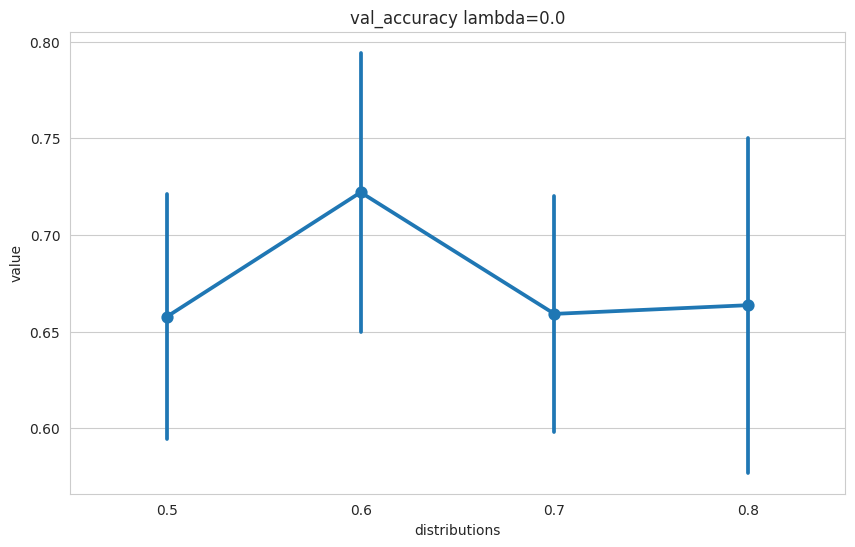

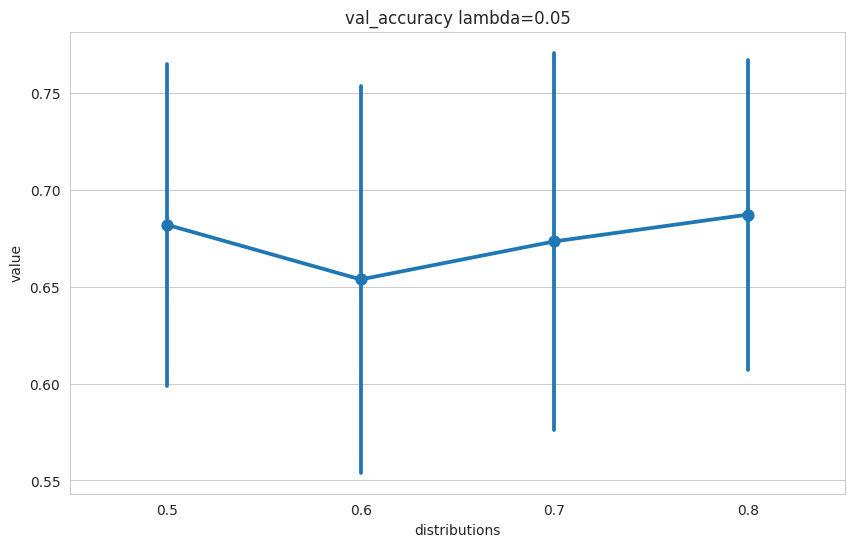

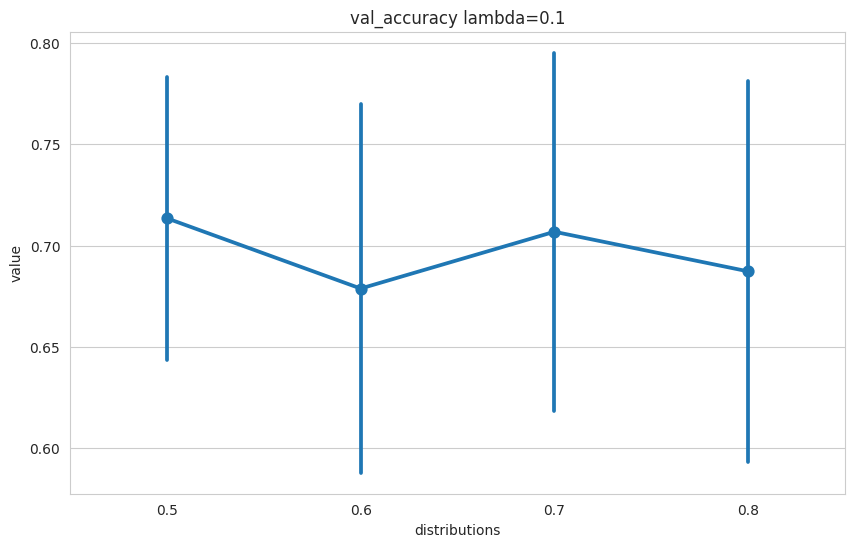

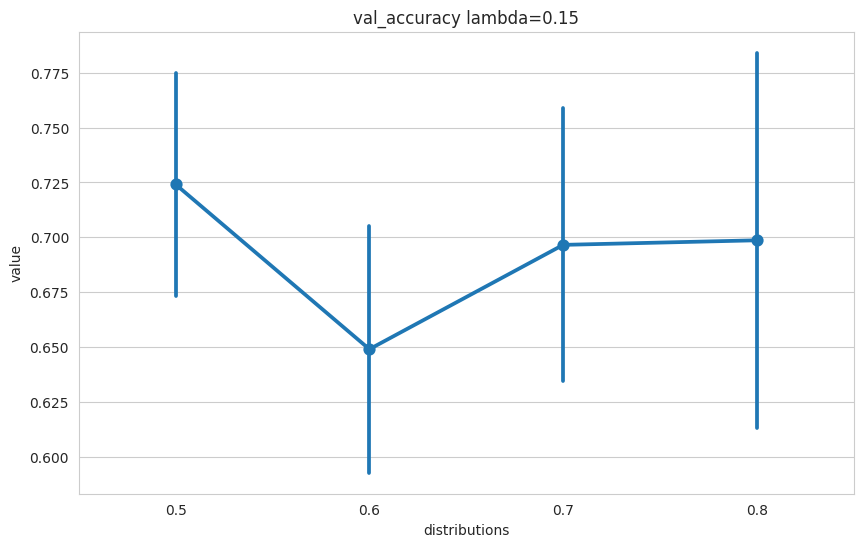

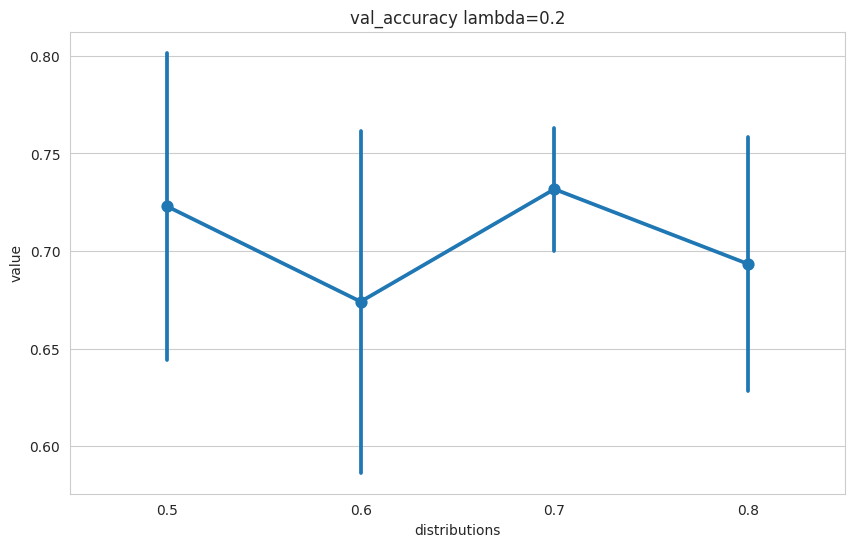

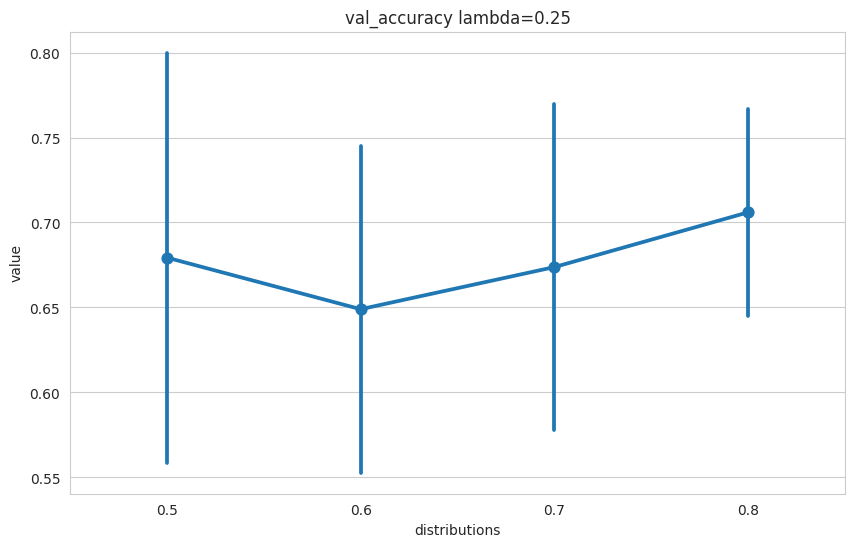

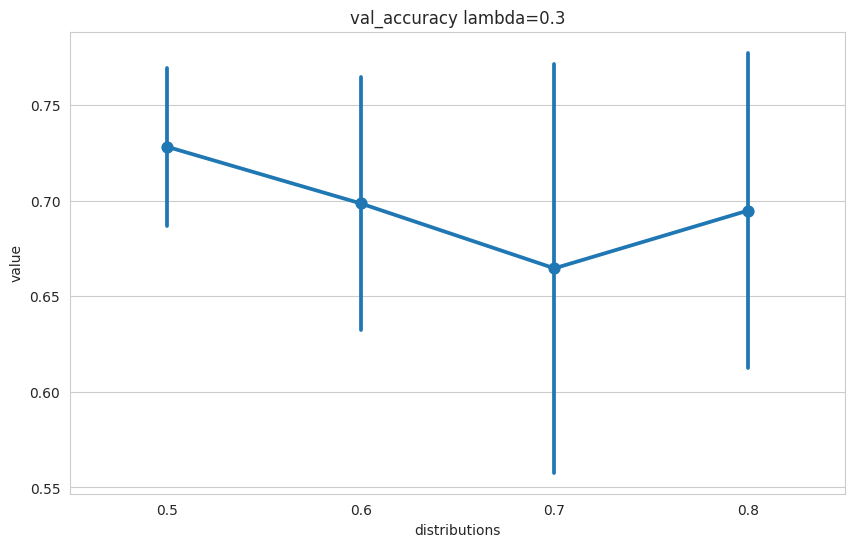

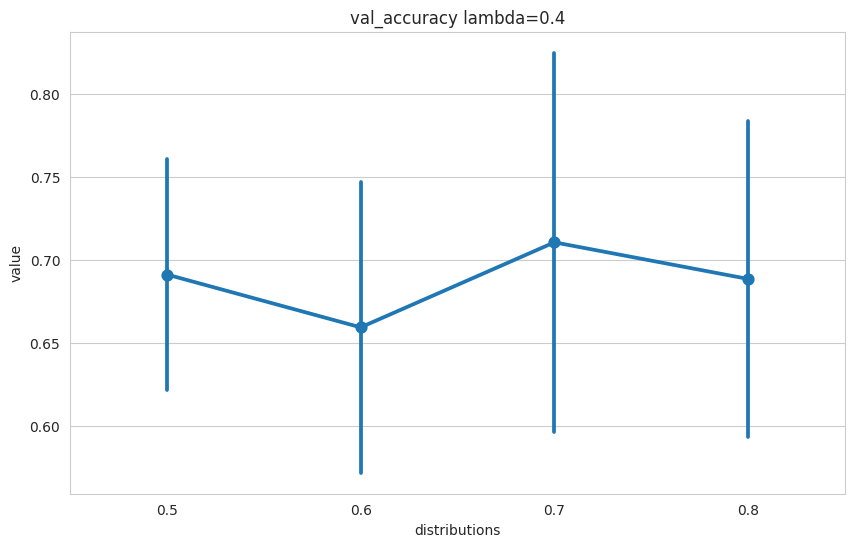

In [524]:
import pandas as pd
import numpy as np

target = 'val_accuracy'
dists = [0.5, 0.6, 0.7, 0.8]
for l in training_lambdas:
    all_p_rules = []
    for d in dists:
        p_rules = [json.loads(open(f'{resultspath}result-l{l}-d{d}-r{r}.json').read())[target][-1] for r in runs]# for d in dists]
        all_p_rules.append(p_rules)
    
    df = pd.DataFrame({
        'value': np.concatenate(all_p_rules),
        'distributions': np.repeat(dists, len(runs))
    })

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.title(f'{target} lambda={l}')
    sns.pointplot(data=df, x='distributions', y='value', errorbar='sd')
    plt.show()

In [ ]:
p_rules

In [ ]:
results_l0_d03 = [json.loads(open(f'{resultspath}result-l0.0-d0.3-r{r}.json').read()) for r in runs]

In [ ]:
df = pd.DataFrame({
    'value': [item for sublist in results_l0_d03 for item in sublist['val_accuracy']],
    'epoch': [i for sublist in results_l0_d03 for i in range(len(sublist['val_accuracy']))],
})

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

training_lambdas = [0.0, 0.05, 0.1, 0.15]
runs = range(10)
dists = [0.3, 0.5, 0.7]
resultspath = 'utkface/results/fairness/'
target = 'val_accuracy'

for l in training_lambdas:
    for d in dists:
        results = [json.loads(open(f'{resultspath}result-l{l}-d{d}-r{r}.json').read()) for r in runs]

        df = pd.DataFrame({
            'value': [item for sublist in results for item in sublist[target]],
            'epoch': [i for sublist in results for i in range(len(sublist[target]))],
        })
#results_l0_d03 = [json.loads(open(f'{resultspath}result-l0.0-d0.3-r{r}.json').read()) for r in runs]

        # Create the plot
        plt.figure(figsize=(10, 6))
        plt.title(f'{target} lambda={l} dist={d}')
        sns.pointplot(data=df, x='epoch', y='value', errorbar='sd')
        plt.show()